## Download dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/mias-mammography")

print("Path to dataset files:", path)

100%|██████████| 312M/312M [00:57<00:00, 5.72MB/s] 

Extracting files...


Path to dataset files: C:\Users\smike18\.cache\kagglehub\datasets\kmader\mias-mammography\versions\3


### import libraries

In [2]:
!pip install -U ultralytics albumentations ipywidgets pyyaml

  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ------------------------------ --------- 0.8/1.0 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 2.4 MB/s eta 0:00:00
Using cached albumentations-2.0.8-py3-none-any.whl (369 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
    --------------------------------------- 0.5/38.9 MB 2.8 MB/s eta 0:00:14
   - -------------------------------------- 1.3/38.9 MB 3.1 MB/s eta 0:00:13
   -- ------------------------------------- 2.1/38.9 MB 3.4 MB/s eta 0:00:11
   -- ------------------------------------- 2.9/38.9 MB 3.5 MB/s eta 0:00:11
   ---- ----------------------------------- 3.9/38.9 MB 3.7 MB/s eta 0:00:10
   --

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


In [3]:
import os
import shutil
import random
from pathlib import Path
import yaml
from itertools import product
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import albumentations as A
from ultralytics import YOLO
from sklearn.model_selection import KFold
from collections import Counter

### Overview of dataset

In [14]:
df = pd.read_csv('mammography_dataset.csv', sep=',')
df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,500,168,26.0


### Class distribution

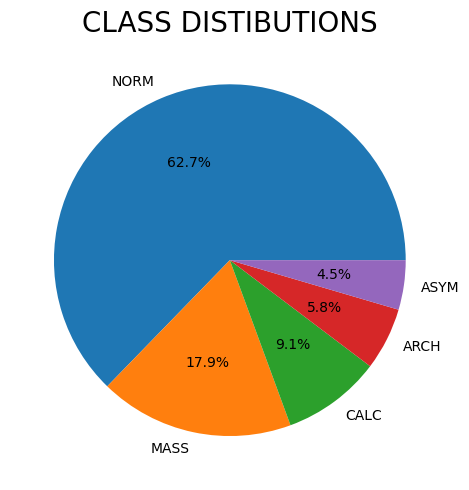

In [15]:
df['CLASS'] = df['CLASS'].apply(lambda x : 'MASS' if x in ['CIRC','SPIC', 'MISC'] else x)

# Define labels as the unique classes
labels = df['CLASS'].value_counts().index.tolist()

# Plot pie chart
plt.figure(figsize=(8, 5), edgecolor='black')
plt.pie(
    df['CLASS'].value_counts(), 
    labels=labels, 
    autopct='%1.1f%%', 
    textprops={'fontsize': 10}
)
plt.title('CLASS DISTIBUTIONS', fontsize=20)
plt.tight_layout()
plt.show()

### Clean dataset and modify csv

In [16]:
df = df.drop(df[(df['CLASS'] != 'NORM') & (df['X'].isnull())].index)
df = df.fillna(0)

# Calculate height and width (2 * RADIUS for both)
df['WIDTH'] = df['RADIUS'] * 2
df['HEIGHT'] = df['RADIUS'] * 2

#label encoding
df['CLASS'] = df['CLASS'].map({'NORM':0 , 'CALC':1, 'MASS':2, 'ARCH':3, 'ASYM':4})

In [17]:
df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,WIDTH,HEIGHT
0,mdb001,G,2,B,535,425,197.0,394.0,394.0
1,mdb002,G,2,B,522,280,69.0,138.0,138.0
2,mdb003,D,0,0,0,0,0.0,0.0,0.0
3,mdb004,D,0,0,0,0,0.0,0.0,0.0
4,mdb005,F,2,B,500,168,26.0,52.0,52.0


### Draw boundary box on 1 mammography

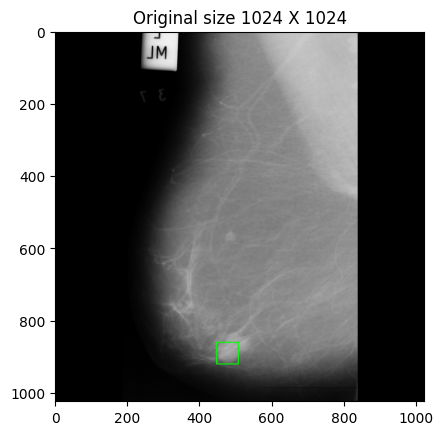

In [18]:
width = 1024
height = 1024

# Load the image
image = cv2.imread(r'C:\Users\smike18\.cache\kagglehub\datasets\kmader\mias-mammography\versions\3\all-mias\mdb005.pgm')

# Define the bounding box in (x_center, y_center, width, height)
x_center = 477
y_center = height - 133 # Coordinate system origin is the bottom-left corner. (convert it to be top-left)
width = 30
height = 30

# Calculate top-left and bottom-right coordinates
x_min = int(x_center - width)
y_min = int(y_center - height)
x_max = int(x_center + width)
y_max = int(y_center + height)

# Draw the bounding box on the image
color = (0, 255, 0)  # Green color in BGR
thickness = 2
cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

# Display the image
plt.title('Original size 1024 X 1024')
plt.imshow(image)

### Prepare data to fit yolov11 structure

In [ ]:
#Create directories

(Path("dataset") / "images").mkdir(parents=True, exist_ok=True)
(Path("dataset") / "labels").mkdir(parents=True, exist_ok=True)

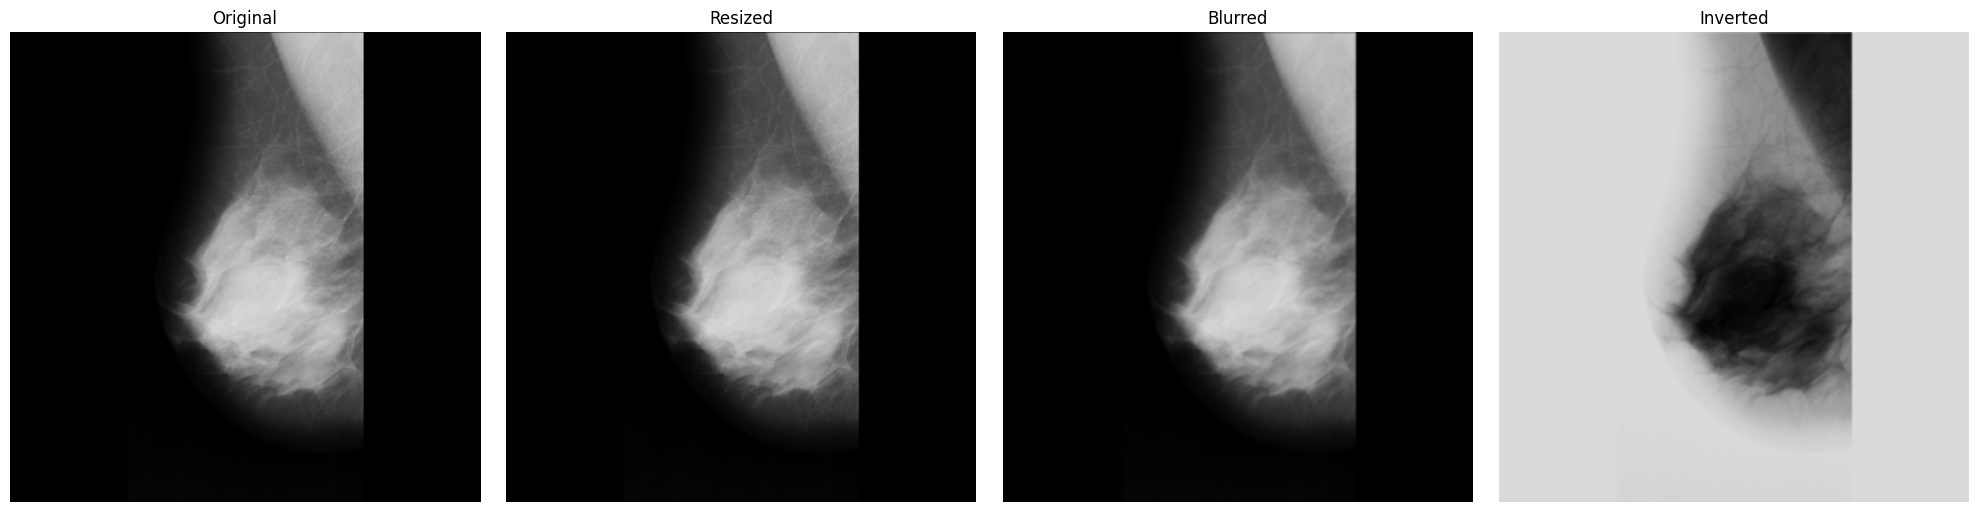

In [22]:
# Step 1: Clean DataFrame — convert problematic columns to numeric
cols_to_fix = ['X', 'Y', 'RADIUS', 'WIDTH', 'HEIGHT']

for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # turn invalid values into NaN

df = df.dropna(subset=['X', 'Y'])  # drop rows where X or Y is still invalid
df = df.fillna(0)  # optional: fill remaining NaNs in other fields with 0

# Ensure types are numeric
df[cols_to_fix] = df[cols_to_fix].astype(float)

# Set up constants
width = 640
height = 640
resize_factor = 0.625

# Create folders if they don't exist
os.makedirs('dataset/images', exist_ok=True)
os.makedirs('dataset/labels', exist_ok=True)

plotted = False  # only plot one example

for row in df.itertuples(index=False):
    REFNUM, BG, CLASS, SEVERITY, X, Y, RADIUS, WIDTH, HEIGHT = row
    image_path = fr'C:\Users\smike18\.cache\kagglehub\datasets\kmader\mias-mammography\versions\3\all-mias\{REFNUM}.pgm'

    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Couldn't read image {image_path}")
        continue

    original = image.copy()
    image = cv2.resize(image, (width, height))
    resized = image.copy()

    image = cv2.GaussianBlur(image, (5, 5), 0)
    blurred = image.copy()

    image = tf.math.subtract(tf.reduce_max(image), image)
    image = image.numpy()
    inverted = image.copy()

    cv2.imwrite(f'dataset/images/{REFNUM}.png', image)

    with open(f'dataset/labels/{REFNUM}.txt', "a") as file:
        if (X != 0) and (Y != 0):
            class_label = CLASS
            X = X * resize_factor
            Y = Y * resize_factor
            Y = height - Y

            x_center_norm = X / width
            y_center_norm = Y / height
            w_norm = WIDTH / width
            h_norm = HEIGHT / height

            annotation = f"{class_label} {x_center_norm:.6f} {y_center_norm:.6f} {w_norm:.6f} {h_norm:.6f} \n"
        else:
            annotation = ''
        file.write(annotation)

    # Plot only the first image with all stages
    if not plotted:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original')

        axes[1].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
        axes[1].set_title('Resized')

        axes[2].imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
        axes[2].set_title('Blurred')

        axes[3].imshow(cv2.cvtColor(inverted, cv2.COLOR_BGR2RGB))
        axes[3].set_title('Inverted')

        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

        plotted = True


### Augmentation

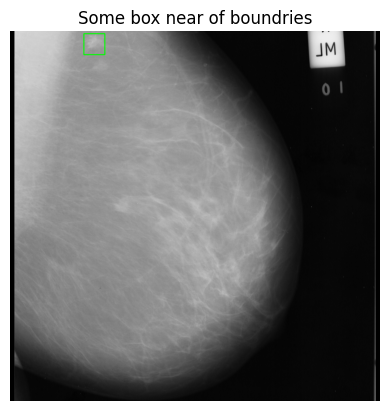

In [24]:
width = 1024
height = 1024

# Load the image
image = cv2.imread(r'C:\Users\smike18\.cache\kagglehub\datasets\kmader\mias-mammography\versions\3\all-mias\mdb144.pgm')

# Define the bounding box in (x_center, y_center, width, height)
x_center = 233
y_center = height - 988 # Coordinate system origin is the bottom-left corner. (convert it to be top-left)
width = 58
height = 58

# Calculate top-left and bottom-right coordinates
x_min = int(x_center - width/2)
y_min = int(y_center - height/2)
x_max = int(x_center + width/2)
y_max = int(y_center + height/2)

# Draw the bounding box on the image
color = (0, 255, 0)  # Green color in BGR
thickness = 2
cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

# Display the image
plt.title('Some box near of boundries')
plt.axis('off')
plt.imshow(image)

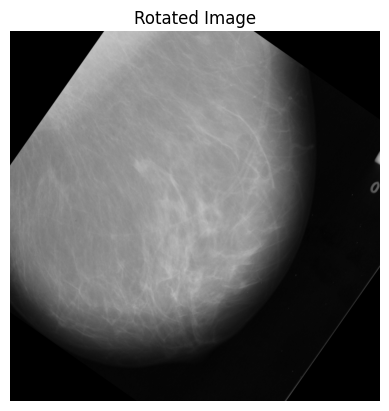

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread(r'C:\Users\smike18\.cache\kagglehub\datasets\kmader\mias-mammography\versions\3\all-mias\mdb144.pgm')  # Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display

# Define the rotation angle and center
angle = -35  # Angle in degrees
(h, w) = image.shape[:2]
center = (w // 2, h // 2)

# Get the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

# Perform the rotation
rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))

# Display the rotated image
plt.imshow(rotated_image)
plt.axis('off')
plt.title('Rotated Image')
plt.show()

In [ ]:
# Define augmentation pipeline
augmentation = A.Compose([
    A.RandomResizedCrop(size=(640,640), scale=(0.8, 1.0), p=0.5),  # Randomly crop between 80% and 100% of the image
    A.Rotate(limit=15, p=1.0),  # Random rotation between -15 and +15 degrees
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.1),
], bbox_params=A.BboxParams(format='yolo',
    min_visibility=0.5))

# Directory paths
image_dir = 'dataset/images'  # Directory with original images
label_dir = 'dataset/labels'  # Directory with corresponding label files in YOLO format

# Number of augmented images to generate per original image
num_augmentations = 1

# Iterate over images in the directory
for image_name in os.listdir(image_dir):
    if image_name.endswith('.png'):  # Adjust image extension as needed
        # Read the image
        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        # Read the corresponding label file
        label_path = os.path.join(label_dir, image_name.replace('.png', '.txt'))
        with open(label_path, 'r') as file:
            bboxes = []
            for line in file:
                line = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, line)
                if (y_center >= height) and (x_center >= width):                  # this condition to prevent box out of boundries
                    bboxes.append([x_center, y_center, width, height, class_id])
                else :
                    continue
        # Generate multiple augmentations
        for i in range(num_augmentations):
            # Apply augmentation
            augmented = augmentation(image=image, bboxes=bboxes)
            aug_image, aug_bboxes = augmented['image'], augmented['bboxes']
            for bbox in aug_bboxes:
                # Save the augmented image
                aug_image_path = os.path.join(image_dir, f"{image_name.replace('.png', '')}_aug_{i + 1}.png")
                cv2.imwrite(aug_image_path, aug_image)

                # Save the augmented label file
                aug_label_path = os.path.join(label_dir, f"{image_name.replace('.png', '')}_aug_{i + 1}.txt")
                with open(aug_label_path, 'w') as file:
                    for bbox in aug_bboxes:
                        file.write(f"{int(bbox[4])} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

print("Processing complete. Augmented images and labels saved.")

Processing complete. Augmented images and labels saved.


### New class distribution

In [28]:
class_label = []
for dir, _, filenames in os.walk('dataset/labels'):
    for filename in filenames:
        with open(os.path.join(dir,filename), 'r') as file:
            file = file.readline()
            if file == '':
                class_label.append('0')
            else:
                file = file.split()
                class_label.append(file[0])

# Get value counts
counts = Counter(class_label)

# Print the result
print(counts)

Counter({'0': 208, '2': 199, '1': 88, '3': 76, '4': 60})


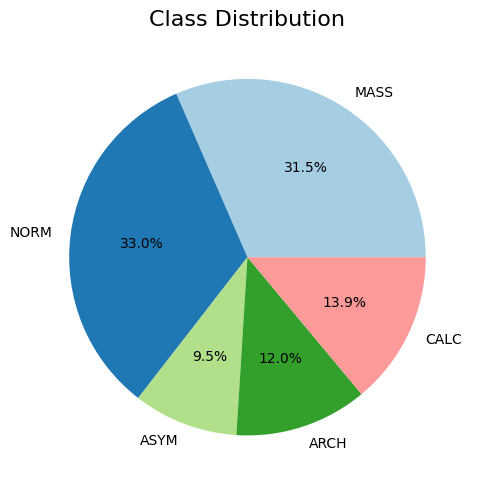

In [29]:
# Pie Chart
plt.figure(figsize=(8, 5))
labels = counts.keys()
# Create a mapping for the labels
label_mapping = {'0': 'NORM', '1': 'CALC', '2': 'MASS', '3': 'ARCH', '4': 'ASYM'}
# Generate the labels using the mapping
labels = [label_mapping[key] for key in counts.keys()]
plt.pie(
    counts.values(), 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=0, 
    colors=plt.cm.Paired.colors, 
    textprops={'fontsize': 10}
)
plt.title('Class Distribution', fontsize=16)
plt.tight_layout()
plt.show()

### Train split

In [30]:
# Paths to the original dataset
images_dir = "dataset/images"  # Path to images directory
labels_dir = "dataset/labels"  # Path to labels directory

# Target directories for splits
output_dirs = {
    "train": {"images": "dataset_holdout/train/images", "labels": "dataset_holdout/train/labels"},
    "val": {"images": "dataset_holdout/val/images", "labels": "dataset_holdout/val/labels"},
    "test": {"images": "dataset_holdout/test/images", "labels": "dataset_holdout/test/labels"}
}

# Create target directories if they don't exist
for split, paths in output_dirs.items():
    for path in paths.values():
        os.makedirs(path, exist_ok=True)

# Define split ratios (train, val, test)
train_ratio = 0.8
test_ratio = 0.2

# Gather all image files (assumes images and labels have the same base names)
image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]
random.shuffle(image_files)

# Calculate split sizes
total_images = len(image_files)
train_count = int(total_images * train_ratio)
test_count = total_images - train_count   # Remaining images for test split

# Split dataset
splits = {
    "train": image_files[:train_count],
    "test": image_files[train_count :]
}

# Copy files to corresponding directories
for split, files in splits.items():
    for file in files:
        # Copy image
        src_image_path = os.path.join(images_dir, file)
        dest_image_path = os.path.join(output_dirs[split]["images"], file)
        shutil.copy(src_image_path, dest_image_path)

        # Copy label (assumes label file has same base name as image)
        file = Path(file)
        label_file = file.with_suffix(".txt")
        src_label_path = os.path.join(labels_dir, label_file)
        dest_label_path = os.path.join(output_dirs[split]["labels"], label_file)
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dest_label_path)

print("Dataset split and files copied successfully!")

Dataset split and files copied successfully!


### Define yaml file

In [31]:
# Define the data for the YAML file
data = {
    'path': '/kaggle/working/dataset_holdout',
    'names': {0:'NORM', 1:'CALC', 2:'MASS', 3:'ARCH', 4:'ASYM'},
    'nc': 5,
    'train': 'train',
    'val': 'val',
    'test': 'test'
}

# Save the data to a YAML file
with open('dataset_holdout/data.yaml', 'w') as file:
    yaml.dump(data, file)

print("data.yaml file created!")

data.yaml file created!


## Train model

In [32]:
# 1. Setup and get labels
dataset_path = Path("dataset_holdout/train")  # replace with 'path/to/dataset' for your custom data
labels = sorted(dataset_path.rglob("*labels/*.txt"))  # all data in 'labels'

# 2. Read YAML and create feature vectors
yaml_file = "dataset_holdout/data.yaml"  # your data YAML with data directories and names dictionary
with open(yaml_file, "r", encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]
cls_idx = sorted(classes.keys())

# Initialize DataFrame
indx = [label.stem for label in labels]
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

# Count instances
for label in labels:
    lbl_counter = Counter()
    with open(label, "r") as lf:
        lines = lf.readlines()
    for line in lines:
        lbl_counter[int(line.split(" ")[0])] += 1
    labels_df.loc[label.stem] = lbl_counter
labels_df = labels_df.fillna(0.0)

# 3. Create k-fold splits
ksplit = 5
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)
kfolds = list(kf.split(labels_df))

# 4. Create fold directories
folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)
for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f"split_{idx}"].loc[labels_df.iloc[train].index] = "train"
    folds_df[f"split_{idx}"].loc[labels_df.iloc[val].index] = "val"

# 5. Setup directories and YAML files
supported_extensions = [".jpg", ".jpeg", ".png"]
images = []
for ext in supported_extensions:
    images.extend(sorted((dataset_path / "images").rglob(f"*{ext}")))

save_path = Path(f"/kaggle/working/{ksplit}-Fold_Cross-val")
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []
for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)
    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )
# 6. Copy images and labels to respective directories
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

C:\Users\smike18\AppData\Local\Temp\ipykernel_3408\809314066.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0)
C:\Users\smike18\AppData\Local\Temp\ipykernel_3408\809314066.py:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` inst

In [33]:
# Define grid search parameters
batch_sizes = [8, 16]
epochs = [100, 150]

# Create all combinations of hyperparameters
grid = list(product(batch_sizes, epochs))

# Path to your initial weights
weights_path = "yolov8n.pt"

# Perform grid search
for batch, ep in grid:
    print(f"batch_size={batch}, epochs={ep}")

    # Loop over each fold
    for k, dataset_yaml in enumerate(ds_yamls):
        print(f"Training on fold {k+1}")

        # Initialize YOLO model
        model = YOLO(weights_path, task="detect")

        # Train model with the current combination of hyperparameters
        model.train(
            data=dataset_yaml,
            epochs=ep,
            batch=batch,
            project="kfold_gridsearch",
            name=f"fold{k+1}_batch{batch}_epochs{ep}",
            patience = 10
        )

batch_size=8, epochs=100
Training on fold 1


100%|██████████| 6.25M/6.25M [00:01<00:00, 3.69MB/s]


Ultralytics 8.3.166  Python-3.10.15 torch-2.7.0+cpu CPU (Intel Core(TM) i5-1035G1 1.00GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=\kaggle\working\5-Fold_Cross-val\split_1\split_1_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fold1_batch8_epochs100, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patienc

train: Scanning C:\kaggle\working\5-Fold_Cross-val\split_1\train\labels... 403 images, 132 backgrounds, 0 corrupt: 100%|██████████| 403/403 [00:02<00:00, 151.17it/s]

train: C:\kaggle\working\5-Fold_Cross-val\split_1\train\images\mdb001.png: 1 duplicate labels removed
train: C:\kaggle\working\5-Fold_Cross-val\split_1\train\images\mdb002_aug_1.png: 1 duplicate labels removed
train: C:\kaggle\working\5-Fold_Cross-val\split_1\train\images\mdb002_aug_3.png: 1 duplicate labels removed
train: C:\kaggle\working\5-Fold_Cross-val\split_1\train\images\mdb005.png: 2 duplicate labels removed
train: C:\kaggle\working\5-Fold_Cross-val\split_1\train\images\mdb005_aug_1.png: 2 duplicate labels removed
train: C:\kaggle\working\5-Fold_Cross-val\split_1\train\images\mdb005_aug_2.png: 2 duplicate labels removed
train: C:\kaggle\working\5-Fold_Cross-val\split_1\train\images\mdb012_aug_3.png: 1 duplicate labels removed
train: C:\kaggle\working\5-Fold_Cross-val\split_1\train\images\mdb013_aug_3.png: 1 duplicate labels removed
train: C:\kaggle\working\5-Fold_Cross-val\split_1\train\images\mdb015.png: 1 duplicate labels removed
train: C:\kaggle\working\5-Fold_Cross-val\spli

train: New cache created: C:\kaggle\working\5-Fold_Cross-val\split_1\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.30.1 ms, read: 8.21.4 MB/s, size: 142.9 KB)


c:\Users\smike18\anaconda3\envs\r-python-env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\kaggle\working\5-Fold_Cross-val\split_1\val\labels... 101 images, 35 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<00:00, 150.78it/s]

val: C:\kaggle\working\5-Fold_Cross-val\split_1\val\images\mdb002_aug_2.png: 1 duplicate labels removed
val: C:\kaggle\working\5-Fold_Cross-val\split_1\val\images\mdb005_aug_3.png: 2 duplicate labels removed
val: C:\kaggle\working\5-Fold_Cross-val\split_1\val\images\mdb010.png: 1 duplicate labels removed
val: C:\kaggle\working\5-Fold_Cross-val\split_1\val\images\mdb010_aug_1.png: 1 duplicate labels removed
val: C:\kaggle\working\5-Fold_Cross-val\split_1\val\images\mdb012.png: 1 duplicate labels removed
val: C:\kaggle\working\5-Fold_Cross-val\split_1\val\images\mdb012_aug_1.png: 1 duplicate labels removed
val: C:\kaggle\working\5-Fold_Cross-val\split_1\val\images\mdb013.png: 1 duplicate labels removed
val: C:\kaggle\working\5-Fold_Cross-val\split_1\val\images\mdb019_aug_1.png: 1 duplicate labels removed
val: C:\kaggle\working\5-Fold_Cross-val\split_1\val\images\mdb021_aug_3.png: 1 duplicate labels removed
val: C:\kaggle\working\5-Fold_Cross-val\split_1\val\images\mdb028_aug_3.png: 1 dup


c:\Users\smike18\anaconda3\envs\r-python-env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to kfold_gridsearch\fold1_batch8_epochs100\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to kfold_gridsearch\fold1_batch8_epochs100
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      3.011      8.363      2.597          4        640:   6%|▌         | 3/51 [01:06<17:45, 22.21s/it]


KeyboardInterrupt: 